In [107]:
import cubehelix
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import seaborn as sns
import msaf       # Develop branch
import mir_eval   # Uri's fork: https://github.com/urinieto/mir_eval
from mir_eval.segment import tree

# Beatuiful seaborn plots
sns.set()
%matplotlib inline

# Colorhelix config
cx = cubehelix.cmap(reverse=True, start=0.2, rot=-0.4)

# SALAMI Path
SALAMI_path = "/home/uri/datasets/Segments/references/"

In [124]:
def gen_synthetic_labels(bounds):
    labels = []
    [labels.append(np.random.random(len(level) - 1)) for level in bounds]
    return labels

def evaluate_flat(ref_times, est_times, w, trim=False):
    ref_times = np.asarray(ref_times).flatten()
    est_times = np.asarray(est_times).flatten()
    ref_inter = np.asarray(zip(ref_times[:], ref_times[1:]))
    est_inter = np.asarray(zip(est_times[:], est_times[1:]))
    p, r, f = mir_eval.segment.detection(ref_inter, est_inter, trim=trim, window=w)
    R2E, E2R = mir_eval.segment.deviation(ref_inter, est_inter, trim=trim)
    print "F: %.2f\t P: %.2f\t R: %.2f" % (f * 100, p * 100, r * 100)
    print "R2E: %.2f\t E2R: %.2f" % (R2E, E2R)
    return f, p, r

def evaluate_hier(bounds1, bounds2, levels1=None, levels2=None, title=None, figsize=(7,3), ratios=[1,1]):
    labels1 = gen_synthetic_labels(bounds1)
    labels2 = gen_synthetic_labels(bounds2)
    tree1 = tree.SegmentTree(bounds1, labels1, levels1)
    tree2 = tree.SegmentTree(bounds2, labels2, levels2)
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=ratios) 
    plt.subplot(gs[0])
    msaf.plotting.plot_tree(tree1, title="Reference", res=None, cmap_id=cx)
    plt.subplot(gs[1])
    msaf.plotting.plot_tree(tree2, title="Estimation", res=None, cmap_id=cx)
    plt.tight_layout()
    res = 0.1
    for ws in [0.5, 3.0, 15, 30, None]:
        if ws is None:
            w = None
        else:
            w = int(ws / res)
        T_o, T_u, T_f = mir_eval.segment.hmeasure(tree1, tree2, transitive=True, window=w, res=res)
        if ws is None:
            ws = np.inf
        print "w: %.1f\t Tu: %.2f\t To: %.2f" % (ws, T_u * 100, T_o * 100)

def remove_level(bounds, levels, level_id):
    for i, level in enumerate(levels):
        if level_id == level:
            bounds.pop(i)
            levels.pop(i)
            break

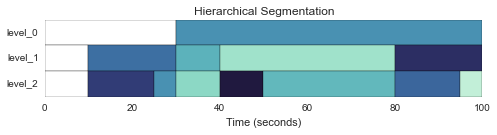

In [126]:
# Synthetic example
est_bounds = [[0, 30, 100], [0, 10, 30, 40, 80, 100], [0, 10, 25, 30, 40, 50, 80, 95, 100]]
est_labels = gen_synthetic_labels(est_bounds)
est_tree = tree.SegmentTree(est_bounds, est_labels)
plt.figure(figsize=(7,2))
msaf.plotting.plot_tree(est_tree, title="Hierarchical Segmentation", res=None, cmap_id=cx)
plt.tight_layout()
plt.savefig("../figs/hier-example.pdf")

F: 57.14	 P: 100.00	 R: 40.00
R2E: 10.00	 E2R: 0.00
w: 0.5	 Tu: 40.00	 To: 100.00
w: 3.0	 Tu: 40.00	 To: 100.00
w: 15.0	 Tu: 39.39	 To: 52.77
w: 30.0	 Tu: 69.46	 To: 49.75
w: inf	 Tu: 80.00	 To: 49.75


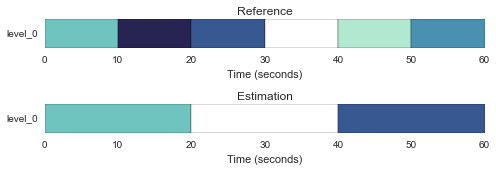

In [129]:
# Flat vs flat
f1 = [[0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 20, 40, 60]]
f, p, r = evaluate_flat(f1, f2, 3, trim=True)
evaluate_hier(f1, f2, title="Flat vs Flat", figsize=(7,2.5))
plt.savefig("../figs/flat-flat.pdf")

w: 0.5	 Tu: 40.00	 To: 100.00
w: 3.0	 Tu: 40.00	 To: 100.00
w: 15.0	 Tu: 51.01	 To: 100.00
w: 30.0	 Tu: 81.76	 To: 100.00
w: inf	 Tu: 88.94	 To: 100.00


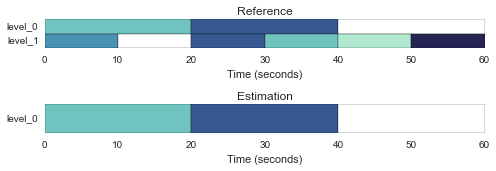

In [130]:
#Hierarchical vs Flat Large Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 20, 40, 60]]
evaluate_hier(h1, f2, title="Hierarchical vs Flat Large Scale", figsize=(7,2.5))
plt.savefig("../figs/hier-flatlarge.pdf")

w: 0.5	 Tu: 100.00	 To: 100.00
w: 3.0	 Tu: 100.00	 To: 100.00
w: 15.0	 Tu: 76.31	 To: 100.00
w: 30.0	 Tu: 58.91	 To: 100.00
w: inf	 Tu: 55.31	 To: 100.00


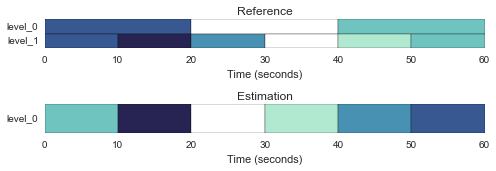

In [131]:
# Hierarchical vs Flat Small Scale
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 10, 20, 30, 40, 50, 60]]
evaluate_hier(h1, f2, title="Hierarchical vs Flat Small Scale", figsize=(7,2.5))
plt.savefig("../figs/hier-flatsmall.pdf")

w: 0.5	 Tu: 100.00	 To: 100.00
w: 3.0	 Tu: 100.00	 To: 100.00
w: 15.0	 Tu: 100.00	 To: 99.13
w: 30.0	 Tu: 100.00	 To: 88.75
w: inf	 Tu: 100.00	 To: 79.41


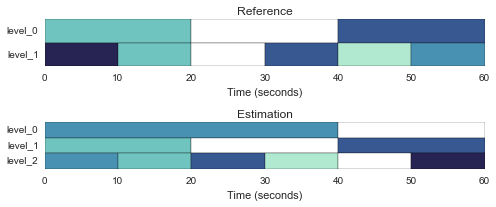

In [132]:
# Hierarchical vs Hierarchical
h1 = [[0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
h2 = [[0, 40, 60], [0, 20, 40, 60], [0, 10, 20, 30, 40, 50, 60]]
evaluate_hier(h1, h2, title="Hierarchical vs Hierarchical", figsize=(7,3))
plt.savefig("../figs/hier-hiercomp.pdf")

w: 0.5	 Tu: 81.12	 To: 78.64
w: 3.0	 Tu: 96.08	 To: 93.02
w: 15.0	 Tu: 80.27	 To: 83.79
w: 30.0	 Tu: 70.53	 To: 89.01
w: inf	 Tu: 67.50	 To: 97.51


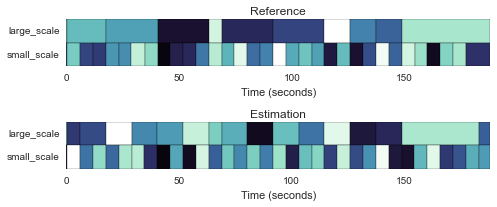

In [133]:
jams_file = "SALAMI_636.jams"
hier_bounds1, hier_labels1, hier_levels1 = msaf.io.read_hier_references(SALAMI_path + jams_file, annotation_id=0)
hier_bounds2, hier_labels2, hier_levels2 = msaf.io.read_hier_references(SALAMI_path + jams_file, annotation_id=1)

# Remove the function level
hier_levels1 = list(hier_levels1)
hier_levels2 = list(hier_levels2)
remove_level(hier_bounds1, hier_levels1, "function")
remove_level(hier_bounds2, hier_levels2, "function")

# Evaluate
evaluate_hier(hier_bounds1, hier_bounds2, hier_levels1, hier_levels2, title="SALAMI vs SALAMI", figsize=(7,3))
plt.savefig("../figs/SALAMI-SALAMI.pdf")

w: 0.5	 Tu: 27.72	 To: 54.54
w: 3.0	 Tu: 33.97	 To: 71.80
w: 15.0	 Tu: 66.25	 To: 70.21
w: 30.0	 Tu: 79.87	 To: 58.09
w: inf	 Tu: 92.73	 To: 41.99


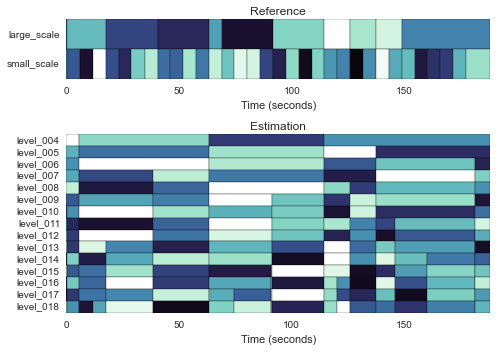

In [134]:
jams_file = "SALAMI_636.jams"
olda_file = "/home/uri/Projects/hier_eval/test/SALAMI_636_OLDA.jams"
hier_bounds1, hier_labels1, hier_levels1 = msaf.io.read_hier_references(SALAMI_path + jams_file)
hier_bounds2, hier_labels2, hier_levels2 = msaf.io.read_hier_references(olda_file)

# Remove the function level from SALAMI
hier_levels1 = list(hier_levels1)
remove_level(hier_bounds1, hier_levels1, "function")

# Evaluate
evaluate_hier(hier_bounds1, hier_bounds2, hier_levels1, hier_levels2, title="SALAMI vs OLDA", figsize=(7,5), ratios=[1,3])
plt.savefig("../figs/SALAMI-OLDA.pdf")